## 互评作业二：网页浏览行为关联规则挖掘
本脚本用于分析用户在网站上的浏览行为数据，挖掘潜在的跳转规律，为网站提供优化导航结构的建议。

代码仓库：https://github.com/HW-VMCL/DataMining

1. 数据预处理:本部分清洗数据，处理缺失值，提取用户浏览记录。

In [58]:
### 分析数据格式并不适合使用pandas库直接读取，因此采用文件读取将数据归类存放。
### 缺失值处理，用户浏览的网页不存在则剔除
import pandas as pd
import matplotlib.pyplot as plt
from efficient_apriori import apriori
Paired_Attributes={}
Attributes=[]
Case=[]
all_visit={}
current_case=None
lost_num=0
with open('anonymous-msweb.data') as data:
    for line in data.readlines():
        line=line.split(',')
        if line[0]=='A':
            Paired_Attributes[line[1]]=line[3:]
            Attributes.append(line[1])
        elif line[0]=='C':
            Case.append([])
        elif line[0]=='V':
            ### 缺失值处理，不在Attribute中的列舍弃
            if line[1] not in Attributes:
                lost_num+=1
                continue
            Case[-1].append(line[1])
            if line[1] in all_visit.keys():
                all_visit[line[1]]+=1
            else:
                all_visit[line[1]]=1
lost_num

0

2. 数据探索性分析：根据上述数据加载与预处理结果，分析最常被访问的页面、页面访问量分布等。

[('1008', 10836), ('1034', 9383), ('1004', 8463), ('1018', 5330), ('1017', 5108), ('1009', 4628), ('1001', 4451), ('1026', 3220), ('1003', 2968), ('1025', 2123)]
Free Downloads
Internet Explorer
Microsoft.com Search
isapi
Products 
Windows Family of OSs
Support Desktop
Internet Site Construction for Developers
Knowledge Base
Web Site Builder's Gallery


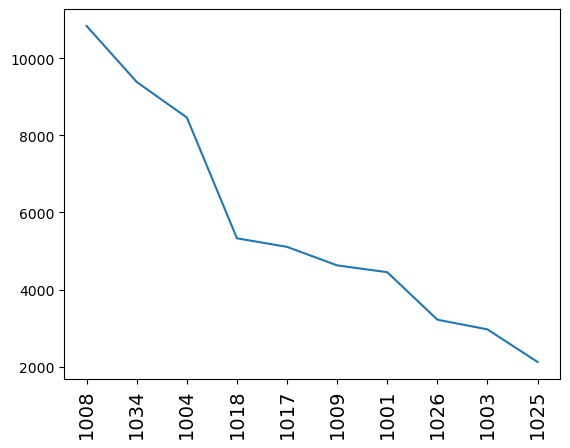

In [81]:
### 统计访问量最高的几个页面，并打印可视化曲线
sorted_all_vis=sorted(all_visit.items(), key = lambda kv: kv[1],reverse=True)
print(sorted_all_vis[:10])
for i in range(10):
    print(eval(Paired_Attributes[sorted_all_vis[i][0]][0])) 
x=[sorted_all_vis[i][0] for i in range(10)]
y=[sorted_all_vis[i][1] for i in range(10)]
plt.plot(x,y)
plt.xticks(rotation=90, fontsize=14)
plt.show()

3.  关联规则挖掘: 使用Apriori算法，根据用户浏览记录计算频繁项集和关联规则。

In [90]:
### 利用efficient_apriori与apriori库，并对比其效果
import apyori

### 利用efficient_apriori库计算关联规则
itemsets, rules = apriori(Case, min_support=0.05,  min_confidence=0)


### 利用efficient_apriori库计算关联规则
ap = list(apyori.apriori(transactions=Case, min_support=0.01,min_confidence=0, min_lift=0))  


{1: {('1001',): 4451, ('1003',): 2968, ('1004',): 8463, ('1008',): 10836, ('1009',): 4628, ('1017',): 5108, ('1018',): 5330, ('1025',): 2123, ('1026',): 3220, ('1034',): 9383, ('1035',): 1791}, 2: {('1001', '1003'): 1806, ('1001', '1018'): 1944, ('1004', '1008'): 1977, ('1004', '1034'): 1743, ('1008', '1009'): 2549, ('1008', '1017'): 2003, ('1008', '1018'): 2390, ('1008', '1034'): 5260}}
16


4.  结果评估: 计算关联规则的支持度、置信度和提升度，得出强关联规则。并对规则进行评价，使用Lift和卡方。（仅在efficient_apyori库下进行）

In [93]:
### 根据两个库得到的结果分别计算支持度、置信度和提升度。
supports=[]
confidences=[]
lifts=[]
bases=[]
adds=[]

for r in ap:
    for x in r.ordered_statistics:
        supports.append(r.support)
        confidences.append(x.confidence)
        lifts.append(x.lift)
        bases.append(list(x.items_base))
        adds.append(list(x.items_add))

result = pd.DataFrame({
    'support':supports,
    'confidence':confidences,
    'lift':lifts,
    'base':bases,
    'add':adds
})

res = result[(result.lift > 0.0) & (result.support > 0.1) & (result.confidence > 0.1)]
res = res.reset_index(drop=True)   #重置索引
print('*'*32)
print('results of package apyori')
print('*'*32)
print(res)

print('*'*32)
print('results of package efficient_apyori')
print('*'*32)
for i in range(len(rules)):
    print(rules[i])

********************************
results of package apyori
********************************
    support  confidence      lift    base           add
0  0.136070    0.136070  1.000000      []        [1001]
1  0.258720    0.258720  1.000000      []        [1004]
2  0.331265    0.331265  1.000000      []        [1008]
3  0.141481    0.141481  1.000000      []        [1009]
4  0.156155    0.156155  1.000000      []        [1017]
5  0.162942    0.162942  1.000000      []        [1018]
6  0.286845    0.286845  1.000000      []        [1034]
7  0.160802    0.160802  1.000000      []  [1008, 1034]
8  0.160802    0.485419  1.692267  [1008]        [1034]
9  0.160802    0.560588  1.692267  [1034]        [1008]
********************************
results of package efficient_apyori
********************************
{1003} -> {1001} (conf: 0.608, supp: 0.055, lift: 4.472, conv: 2.207)
{1001} -> {1003} (conf: 0.406, supp: 0.055, lift: 4.472, conv: 1.530)
{1018} -> {1001} (conf: 0.365, supp: 0.059, lift: 

5.  结果分析与应用: 分析得到的关联规则，为网站提供导航结构优化建议，以提升用户体验。
根据以上的结果可知，强关联规则为{1034} -> {1008}以及{1008} -> {1034}，即Free Downloads -> Internet Explorer以及Internet Explorer -> Free Downloads。
优化建议：Free Downloads以及Internet Explorer页面上添加彼此的链接。
此外，{1003} -> {1001}，{1009} -> {1008}，{1018} -> {1008}，{1001} -> {1018}，{1001} -> {1003}规则的置信度较高，可以添加相应的跳转链接。

6. 可视化展示
以下给出efficient_apyori下的support和confidence、support和lift关系的散点图。

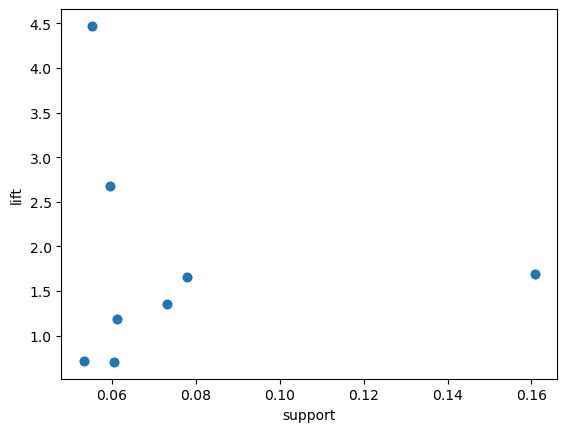

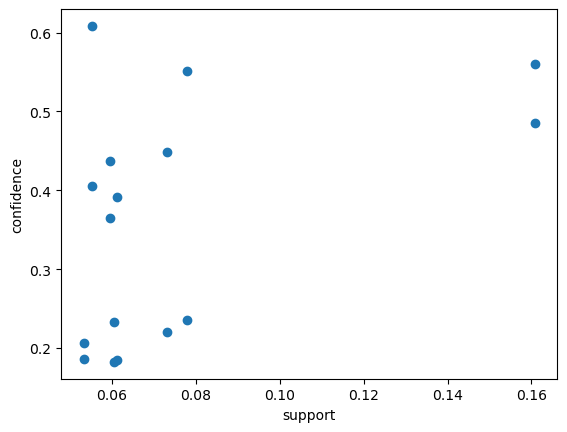

In [102]:
supp=[]
lift=[]
conf=[]
for i in range(len(rules)):
    supp.append(rules[i].support)
    lift.append(rules[i].lift)
    conf.append(rules[i].confidence)
plt.xlabel('support')
plt.ylabel('lift')
plt.scatter(supp,lift)
plt.show()
plt.clf()
plt.xlabel('support')
plt.ylabel('confidence')
plt.scatter(supp,conf)
plt.show()